# Analysis of crime data trend in Maryland (1990-2017)

In this tutorial, we attempt to find the number of crimes and potential trends between crimes and counties in Maryland from 1990 to 2017.

Contributors: Shuo Wang and Chenhongshu Yu

# Table of Contents:

1. Introduction

2. Data Collection and Processing

3. Data Visualization

4. Analysis

# 1. Introduction

As the student live in College Park, Prince George's County, MD, we often get alert messages from UMPD around the campus. After seeing many different Safety Notice of data from the UMPD website, we are curious about the total crime number and type in state-wide Maryland. We found a dataset "Violent Crime & Property Crime by Municipality: 2000 to Present" from "opendata.maryland.gov", which provides various detailed information about crimes happened in Maryland from 1990 to 2017. We attempt to utilize these data to provide a number of different crimes and their trend over time (1990-2017). Those data are separated by different jurisdictions, counties for each year, with detailed information such as each crime and its percentage over population, and more. By those critical detailed information, we are able to achieve our goal from our motivation to the realistic analysis.

Below we will take you through all the steps that the function applies to tidy the data and build data visualization.

# 2. Data Collection and Processing

In [160]:
from sodapy import Socrata
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from statsmodels.formula.api import ols
import statistics

The first step is to access data in opendata.maryland.gov. We use provided API port in opendata.maryland.gov to get access to the dataset. It uses pandas and Socrata. Since we are not a authenticated client from their website, we get a warning, but it does not affect us getting the full information from the dataset. So, our analysis will not be impacted. In the dataset, there are total 3862 rows, then we return first 3862 rows to avoid missing data.

In [161]:
from sodapy import Socrata
import pandas as pd

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("opendata.maryland.gov", None)

# First 3862 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("2p5g-xrcb", limit=3862)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df.head()

,jurisdiction,county,year,population,murder,rape,robbery,agg_assault,b_e,larceny_theft,...,agg_assault_per_100_000_people,b_e_per_100_000_people,larceny_theft_per_100_000_people,m_v_theft_per_100_000_people,percent_change,violent_crime_percent_change,property_crime_percent_change,overall_percent_change_per_100_000_people,violent_crime_rate_percent_change_per_100_000_people,property_crime_rate_percent_change_per_100_000_people
0,Aberdeen,Harford,1990,13087,1,1,26,58,236,542,...,443.2,1803.3,4141.5,374.4,NaN,NaN,NaN,NaN,NaN,NaN
1,Aberdeen,Harford,1991,13301,0,6,14,80,202,707,...,601.5,1518.7,5315.4,451.1,17.100,16.300,17.200,15.200,14.400,15.300
2,Aberdeen,Harford,1992,13432,0,8,18,70,138,552,...,521.1,1027.4,4109.6,253.1,-23.300,-4.00,-25.300,-24.00,-4.900,-26.00
3,Aberdeen,Harford,1993,13703,0,12,16,112,142,537,...,817.3,1036.3,3918.8,226.2,3.700,45.800,-1.900,1.600,42.900,-3.900
4,Aberdeen,Harford,1994,13815,0,3,16,99,117,565,...,716.6,846.9,4089.7,289.5,-1.200,-15.700,1.700,-2.00,-16.400,0.900


To check the total number of rows in the dataset if it is legit.

In [162]:
len(df)

3862

Next, we do some data processing. Since each column is string type wich is not conventient for calculations and graphing, we convert their type to integer. We create a new column called 'crime ratio' for futher analysis. The crime ratio is total crime number over total polulation.

In [163]:
df = df.astype({'year':'int'})
df = df.astype({'violent_crime_total':'int'})
df = df.astype({'property_crime_totals':'int'})
df = df.astype({'grand_total':'int'})
df = df.astype({'population':'int'})
df = df.astype({'grand_total':'int'})
df['crime ratio'] = df['grand_total']/df['population']

Then we remove some useless data to keep the dataframe clean and neat. 
To note, the reason why we remove "QueenAnne's" from the County column is that there is already a Queen Anne's in the dataset. This QueenAnne's is duplicated (most likely as a typing in error from the dataset)

In [164]:
df.drop(df.iloc[:, 15:32], inplace = True, axis = 1)
df.drop(df.iloc[:, 4:11], inplace = True, axis = 1)
df.drop('violent_crime_percent', inplace = True, axis = 1)
df.head()

,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
0,Aberdeen,Harford,1990,13087,913,86,827,0.069764
1,Aberdeen,Harford,1991,13301,1069,100,969,0.080370
2,Aberdeen,Harford,1992,13432,820,96,724,0.061048
3,Aberdeen,Harford,1993,13703,850,140,710,0.062030
4,Aberdeen,Harford,1994,13815,840,118,722,0.060803


# 3. Data Visualization

At the first step of data visualization, we make every 10 years as a group, so we have 3 groups in total (90s, 00s, 10s). We want to figure out the relation of total number of crimes in each group with varied 23 counties. The bar chart would directly deliver the aspects of which county having the most crime numbers in the designated time group. 

Also, having two auxiliary lines, mean and median, would vividly deliver the idea of the difference in numbers of total crimes for each county.

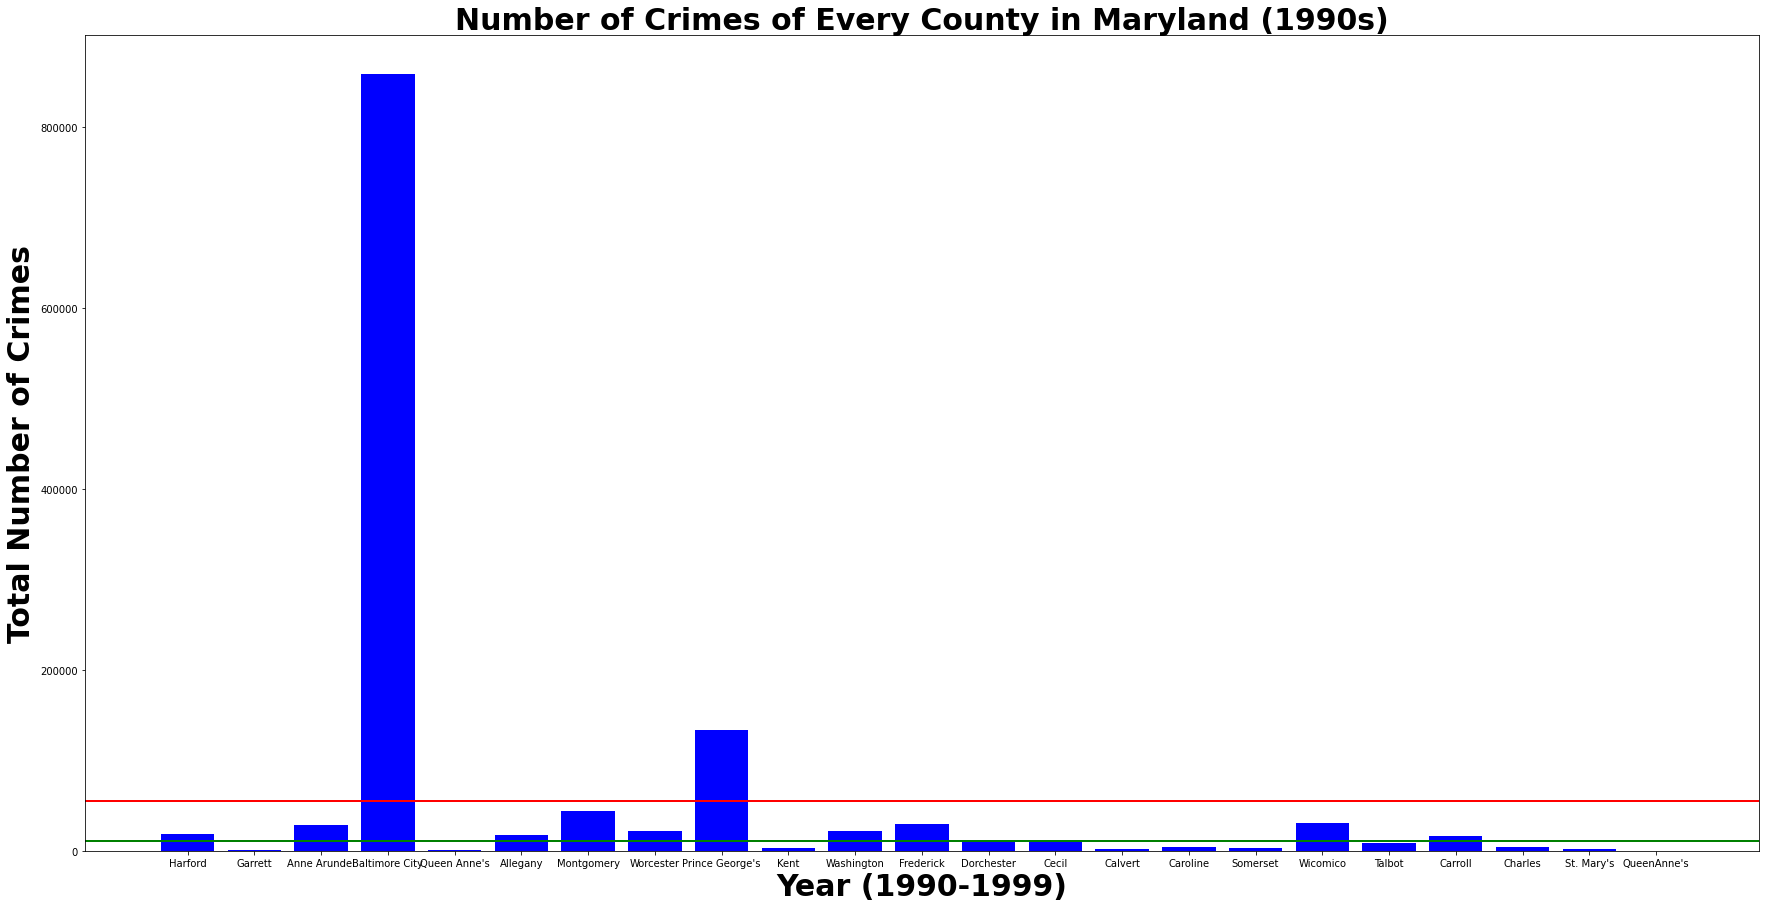

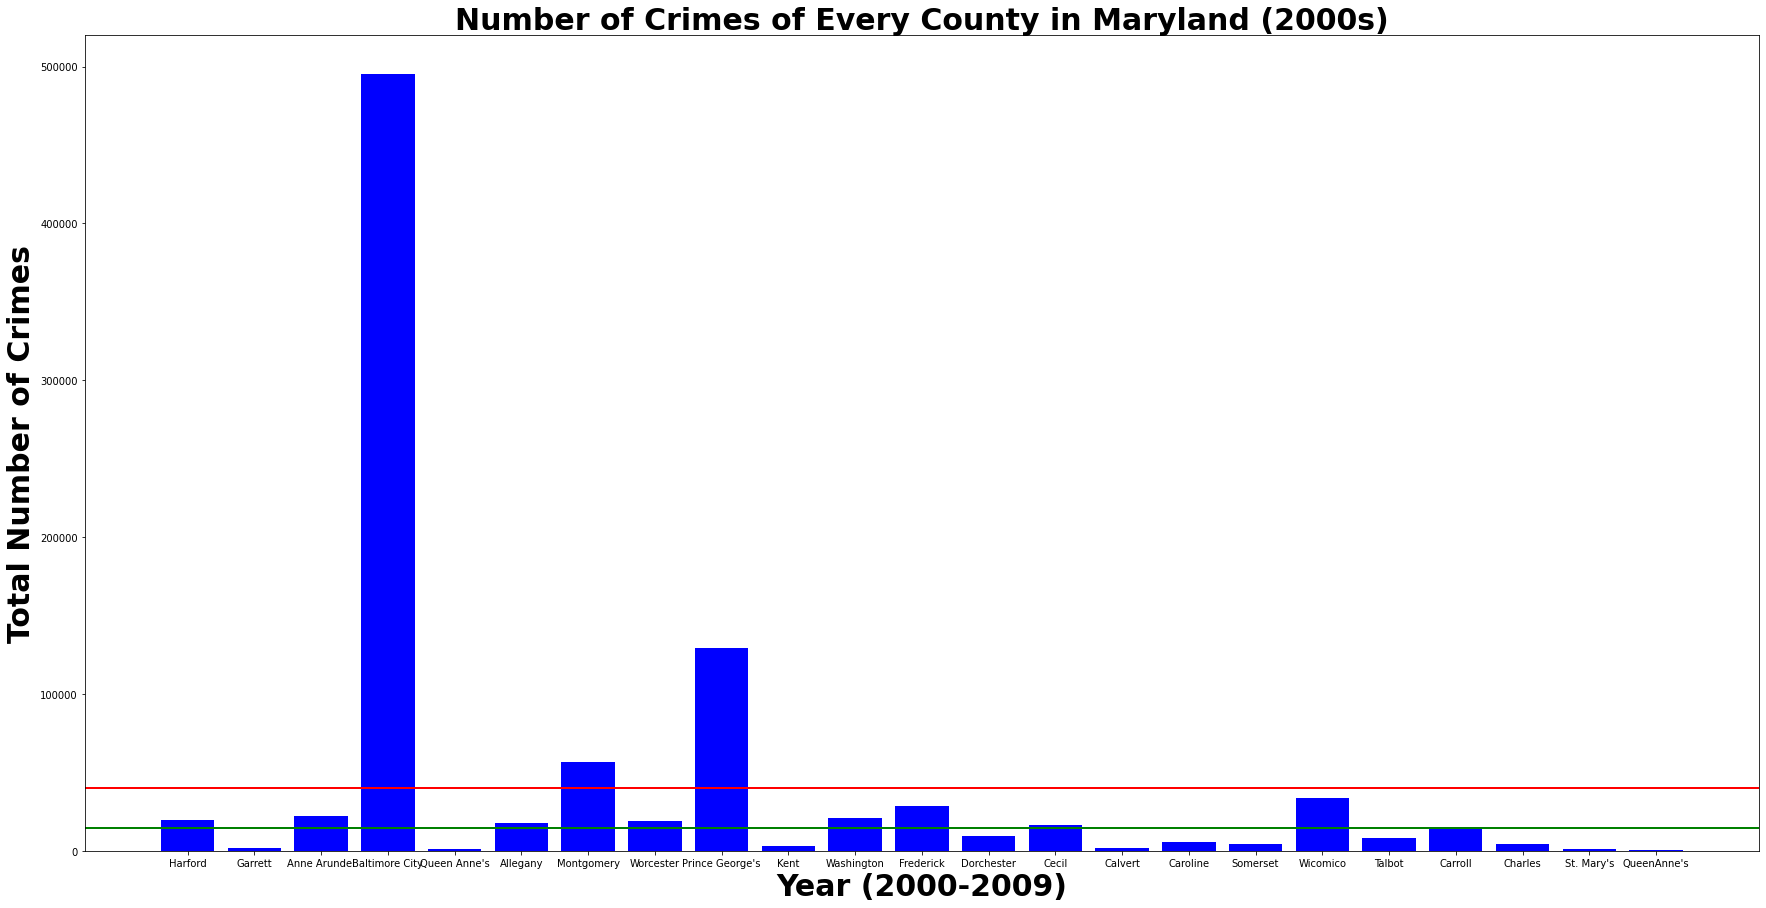

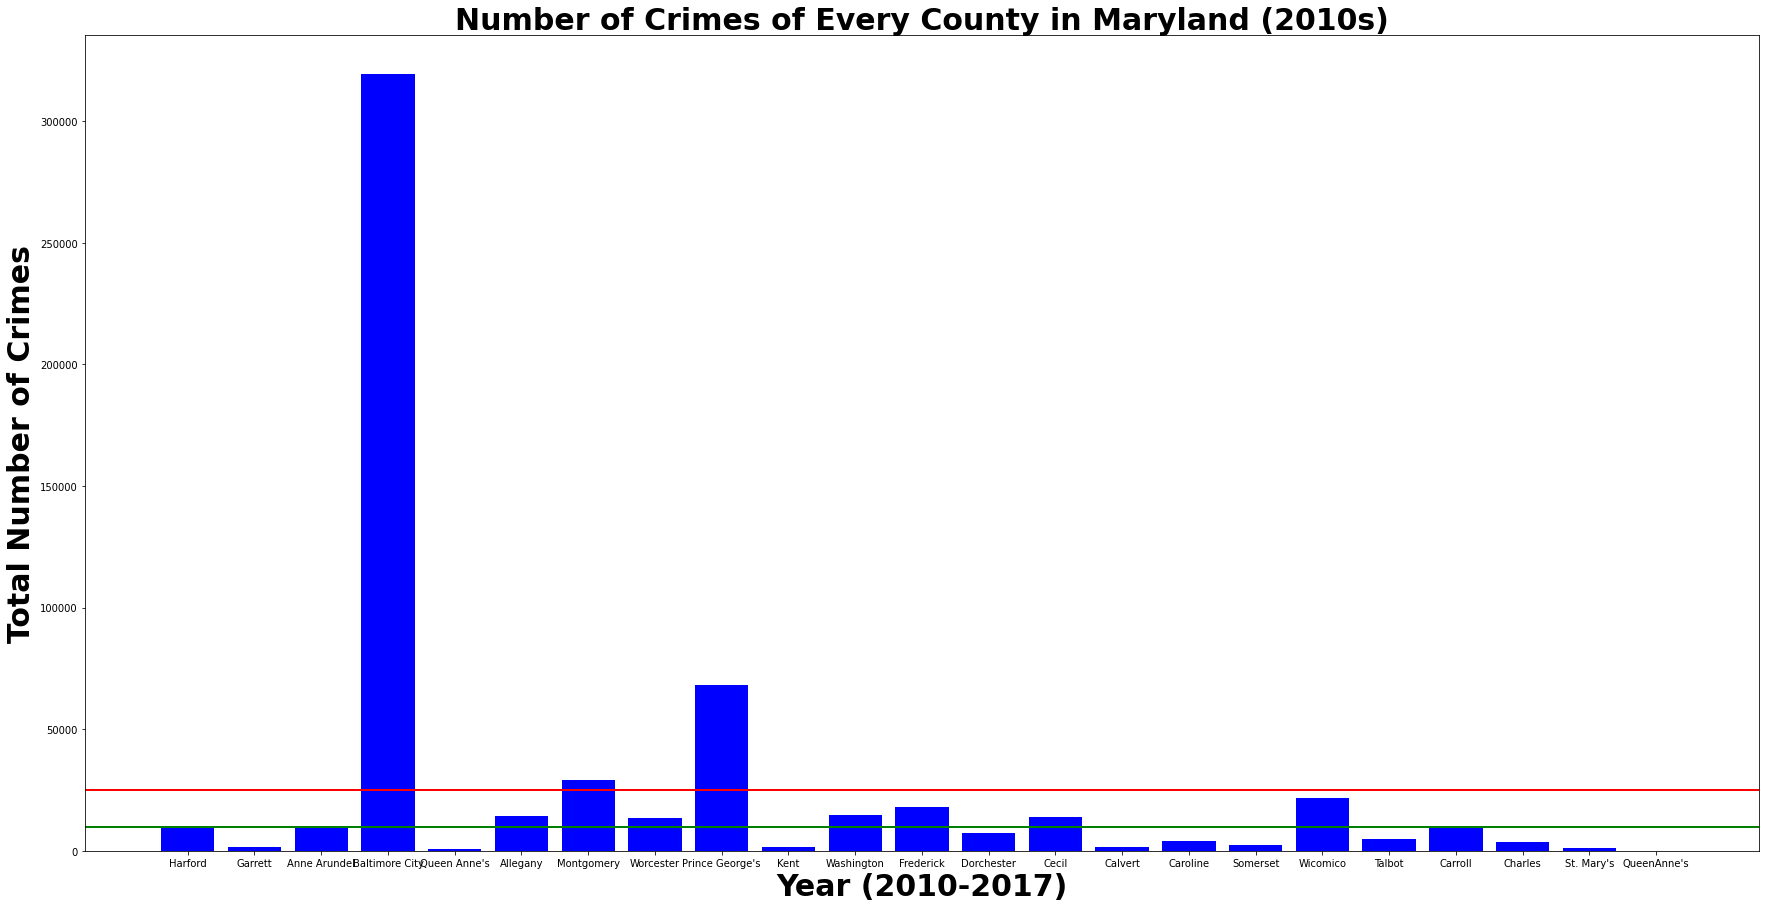

In [165]:
# in year 1990-1999
year90s = df[df["year"] < 2000]
# in year 2000-2009
year00s = df[df["year"] < 2010]
year00s = year00s[year00s["year"] >= 2000]
# in year 2010-2017
year10s = df[df["year"] >= 2010]

county = df["county"].drop_duplicates()

x_pos = [i for i, _ in enumerate(county)]

# 1990s
arr_total90s = []
for i in enumerate(county):
    county_data90s = year90s[year90s["county"] == i[1]]
    total = 0
    for j in enumerate(county_data90s["grand_total"]):
        total = total + int(j[1])
    arr_total90s.append(total)

mean90s = round(sum(arr_total90s) / len(arr_total90s), 2)
median90s = statistics.median(arr_total90s)

plt.subplots(figsize = (30, 15))
plt.bar(x_pos, arr_total90s, color = 'blue')
plt.title("Number of Crimes of Every County in Maryland (1990s)", size = 30, weight = 'bold')
plt.xlabel("Year (1990-1999)", size = 30, weight = 'bold')
plt.ylabel("Total Number of Crimes", size = 30, weight = 'bold')
plt.xticks(x_pos, county)
plt.axhline(mean90s, color = "red", linewidth = 2)
plt.axhline(median90s, color = "green", linewidth = 2)
plt.show()

# 2000s
arr_total00s = []
for i in enumerate(county):
    county_data00s = year00s[year00s["county"] == i[1]]
    total = 0
    for j in enumerate(county_data00s["grand_total"]):
        total = total + int(j[1])
    arr_total00s.append(total)

mean00s = round(sum(arr_total00s) / len(arr_total00s), 2)
median00s = statistics.median(arr_total00s)

    
plt.subplots(figsize = (30, 15))
plt.bar(x_pos, arr_total00s, color = 'blue')
plt.title("Number of Crimes of Every County in Maryland (2000s)", size = 30, weight = 'bold')
plt.xlabel("Year (2000-2009)", size = 30, weight = 'bold')
plt.ylabel("Total Number of Crimes", size = 30, weight = 'bold')
plt.xticks(x_pos, county)
plt.axhline(mean00s, color = "red", linewidth = 2)
plt.axhline(median00s, color = "green", linewidth = 2)
plt.show()

# 2010s
arr_total10s = []
for i in enumerate(county):
    county_data10s = year10s[year10s["county"] == i[1]]
    total = 0
    for j in enumerate(county_data10s["grand_total"]):
        total = total + int(j[1])
    arr_total10s.append(total)

mean10s = round(sum(arr_total10s) / len(arr_total10s), 2) 
median10s = statistics.median(arr_total10s)
    
plt.subplots(figsize = (30, 15))
plt.bar(x_pos, arr_total10s, color = 'blue')
plt.title("Number of Crimes of Every County in Maryland (2010s)", size = 30, weight = 'bold')
plt.xlabel("Year (2010-2017)", size = 30, weight = 'bold')
plt.ylabel("Total Number of Crimes", size = 30, weight = 'bold')
plt.xticks(x_pos, county)
plt.axhline(mean10s, color = "red", linewidth = 2)
plt.axhline(median10s, color = "green", linewidth = 2)
plt.show()

## Analysis of three bar charts above:

By analyzing three bar charts above, we could look them in two ways.

First, looking at an individual chart, in every chart, there is an outstanding column "Baltimore City" having the most number of crimes in Maryland, which predictedly impact the mean value auxiliary line enormously. That is why we also need the median auxiliary line to help us visualize the correlation between every county's total crime number in the designated period.

Second, looking at three charts together, we would easily and clearly notice that on the y-axis, "the total numer of crimes" decreases significantly in numbers with the year increases. We can assmue that with the year increases, the society gets much more civilized with better education provided in Maryland, and other government policy regarding crime controls. 

However, the second analyzation is not intuitively shown by the change of the graph. So, we would like to do more analysis with direct visualization about it later on.

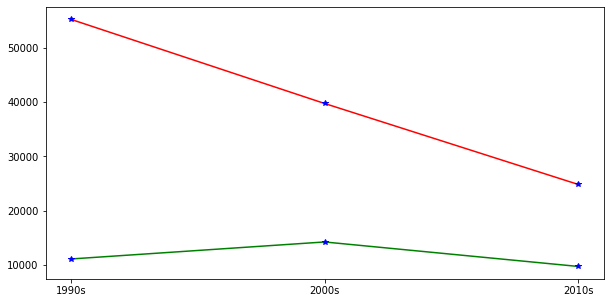

In [166]:
# average trend
plt.subplots(figsize = (10, 5))
mean_list = [mean90s, mean00s, mean10s]
median_list = [median90s, median00s, median10s]
year_list = ["1990s", "2000s", "2010s"]

plt.plot(year_list, mean_list, color = "red")
plt.plot(year_list, mean_list, "*", color = "blue")

plt.plot(year_list, median_list, color = "green")
plt.plot(year_list, median_list, "*", color = "blue")

plt.show()

The above graph provides the trend of mean and median value from all three bar charts above of all counties' total number of crimes. 

From our analyzation, we could see that the mean value shrink down by the time passes. The linear decreasing trend in mean value gives some idea of total number of crimes decreasing in the development of civilization happened in the state of Maryland. 

However, the median value line tells us something different. The median value line is not as linear as mean value line that it has a peak in 2000s (2000-2009) compared with 1990s and 2010s. This reveals that although the total number of crimes happened in Maryland decreases in a significant number, the average number of crimes among each county in Maryland increases from 1990s, and decreases back until 2010s. This analysis gives more aspects of data, especially the average number of total crimes in every county. 

The interesting thing here is we get this average analyzation not from the mean value, but the median value instead. The main reason causes this is we have a giant outlier "Baltimore City" (if we plot all those numbers among every county in a violinplot). That is why we need to rely on multiple analyzation for the data

## Special Analysis of Baltimore City 

First, we need to wash the dataFrame with only data in Baltimore City County.

In [167]:
baltimore_city_data = df[df["county"] == "Baltimore City"]
baltimore_city_data.head()

,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
84,Baltimore,Baltimore City,1990,736014,79145,18006,61139,0.107532
85,Baltimore,Baltimore City,1991,748099,86512,19094,67418,0.115642
86,Baltimore,Baltimore City,1992,755517,91531,21860,69671,0.121150
87,Baltimore,Baltimore City,1993,732968,93568,22006,71562,0.127656
88,Baltimore,Baltimore City,1994,739180,94276,21011,73265,0.127541


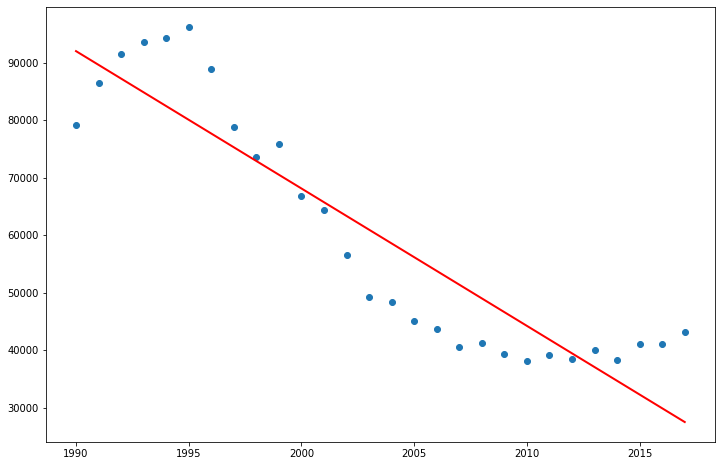

In [168]:
baltimore_city_data = baltimore_city_data.astype({'year':'int'})
baltimore_city_data = baltimore_city_data.astype({'grand_total':'int'})
plt.subplots(figsize = (12, 8))
plt.scatter(baltimore_city_data["year"], baltimore_city_data["grand_total"])

reg = linear_model.LinearRegression()
year = baltimore_city_data["year"].values.reshape(-1,1)
yearly_crime_number = baltimore_city_data["grand_total"].tolist()
regfit = reg.fit(year, yearly_crime_number)
y = reg.predict(year)
plt.plot(year, y, color = 'red', linewidth = 2)

plt.show()

It is clear that seeing trends from previous bar chart is diffcult. There are two reasons for that, one is our time interval is too large and the orther is bar chart is good to see amount but hard to see changes. Thus, we change our data visualization to the total crime number for each county and for each year. In that case, we hope to get a clear changes for each county and then conclude the averall trend for Maryland State.

In the scatter graph above with the linear regression line, we could also get the idea that the total number of crimes happened in the "most violent" city decreases while year increasing (the progress in civilization).

## Another Data Visualiztion based on Different Ideas

The first thing we do is to get two unique lists represents county names and years. These can be a good reference when ploting data. We can clearly find that there are total 23 counties in the dataset and time span is from 1990 to 2017.

In [169]:
counties = df['county'].drop_duplicates()
print(counties)
print("Total number of counties is " + str(len(counties)))

0               Harford
28              Garrett
56         Anne Arundel
84       Baltimore City
112        Queen Anne's
123            Allegany
139          Montgomery
194           Worcester
222     Prince George's
250                Kent
306          Washington
319           Frederick
448          Dorchester
503               Cecil
588             Calvert
796            Caroline
923            Somerset
999            Wicomico
1129             Talbot
1733            Carroll
1936            Charles
2135         St. Mary's
2989        QueenAnne's
Name: county, dtype: object
Total number of counties is 23


In [170]:
years = df['year'].drop_duplicates()
print(years)

0     1990
1     1991
2     1992
3     1993
4     1994
5     1995
6     1996
7     1997
8     1998
9     1999
10    2000
11    2001
12    2002
13    2003
14    2004
15    2005
16    2006
17    2007
18    2008
19    2009
20    2010
21    2011
22    2012
23    2013
24    2014
25    2015
26    2016
27    2017
Name: year, dtype: int64


After that, we calcualte total number of crimes for each county for each year. We iterate those two lists above and add up each value(poulation, total crime, total violent crime and total property crime). Then we add those summerized value as a new row to the dataset with jurisdiction name as ALL. To notice, we reset the crime ratio since it cannnot be simply added up. We need to recalculate the ration based new summerized values.

In [171]:
for year in years:
    for name in counties:
        total = 0
        popu = 0
        vio = 0
        pro = 0
        for i in range(0,len(df.index)):
            if df.iat[i,1] == name and df.iat[i,2] == year:
               # print(type(df.iat[i,3]))
                popu += df.iat[i,3]
                total += df.iat[i,4]
                vio += df.iat[i,5]
                pro += df.iat[i,6]
        df.loc[len(df.index)] = ['ALL',name,year,popu,total,vio,pro,0]
            

Here, we only show the summerized value for further data visualization.

In [172]:
df = df[df.jurisdiction == "ALL"]
df

,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
3862,ALL,Harford,1990,30899,1913,182,1731,0.0
3863,ALL,Garrett,1990,6265,128,26,102,0.0
3864,ALL,Anne Arundel,1990,33187,2714,432,2282,0.0
3865,ALL,Baltimore City,1990,736014,79145,18006,61139,0.0
3866,ALL,Queen Anne's,1990,2097,84,7,77,0.0
...,...,...,...,...,...,...,...,...
4501,ALL,Talbot,2017,19257,526,41,485,0.0
4502,ALL,Carroll,2017,52302,1186,169,1017,0.0
4503,ALL,Charles,2017,13242,436,61,375,0.0
4504,ALL,St. Mary's,2017,3912,71,11,60,0.0


Then we reindex the dataframe and assign it to cleaned_df.

In [173]:
df.reset_index(inplace = True)
cleaned_df = df[["jurisdiction","county", "year", "population","grand_total", "violent_crime_total","property_crime_totals","crime ratio"]]
cleaned_df

,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
0,ALL,Harford,1990,30899,1913,182,1731,0.0
1,ALL,Garrett,1990,6265,128,26,102,0.0
2,ALL,Anne Arundel,1990,33187,2714,432,2282,0.0
3,ALL,Baltimore City,1990,736014,79145,18006,61139,0.0
4,ALL,Queen Anne's,1990,2097,84,7,77,0.0
...,...,...,...,...,...,...,...,...
639,ALL,Talbot,2017,19257,526,41,485,0.0
640,ALL,Carroll,2017,52302,1186,169,1017,0.0
641,ALL,Charles,2017,13242,436,61,375,0.0
642,ALL,St. Mary's,2017,3912,71,11,60,0.0


As mentioned above, we cleaned our crime ration data. At this part, we calculate the ratio for those summerized data and save to the crime ratio column.

In [174]:
for i in range(0,len(cleaned_df.index)):
    cleaned_df.iat[i,7] = cleaned_df.iat[i,4] / cleaned_df.iat[i,3] 
cleaned_df

/var/folders/h4/98bnj8h50j38nq8bdg3hpzf80000gn/T/ipykernel_9753/2289561735.py:2: RuntimeWarning: invalid value encountered in long_scalars
  cleaned_df.iat[i,7] = cleaned_df.iat[i,4] / cleaned_df.iat[i,3]


,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
0,ALL,Harford,1990,30899,1913,182,1731,0.061911
1,ALL,Garrett,1990,6265,128,26,102,0.020431
2,ALL,Anne Arundel,1990,33187,2714,432,2282,0.081779
3,ALL,Baltimore City,1990,736014,79145,18006,61139,0.107532
4,ALL,Queen Anne's,1990,2097,84,7,77,0.040057
...,...,...,...,...,...,...,...,...
639,ALL,Talbot,2017,19257,526,41,485,0.027315
640,ALL,Carroll,2017,52302,1186,169,1017,0.022676
641,ALL,Charles,2017,13242,436,61,375,0.032926
642,ALL,St. Mary's,2017,3912,71,11,60,0.018149


In [175]:
cleaned_df

,jurisdiction,county,year,population,grand_total,violent_crime_total,property_crime_totals,crime ratio
0,ALL,Harford,1990,30899,1913,182,1731,0.061911
1,ALL,Garrett,1990,6265,128,26,102,0.020431
2,ALL,Anne Arundel,1990,33187,2714,432,2282,0.081779
3,ALL,Baltimore City,1990,736014,79145,18006,61139,0.107532
4,ALL,Queen Anne's,1990,2097,84,7,77,0.040057
...,...,...,...,...,...,...,...,...
639,ALL,Talbot,2017,19257,526,41,485,0.027315
640,ALL,Carroll,2017,52302,1186,169,1017,0.022676
641,ALL,Charles,2017,13242,436,61,375,0.032926
642,ALL,St. Mary's,2017,3912,71,11,60,0.018149


Then, we plot the first version of summerized data. 

## First Version:

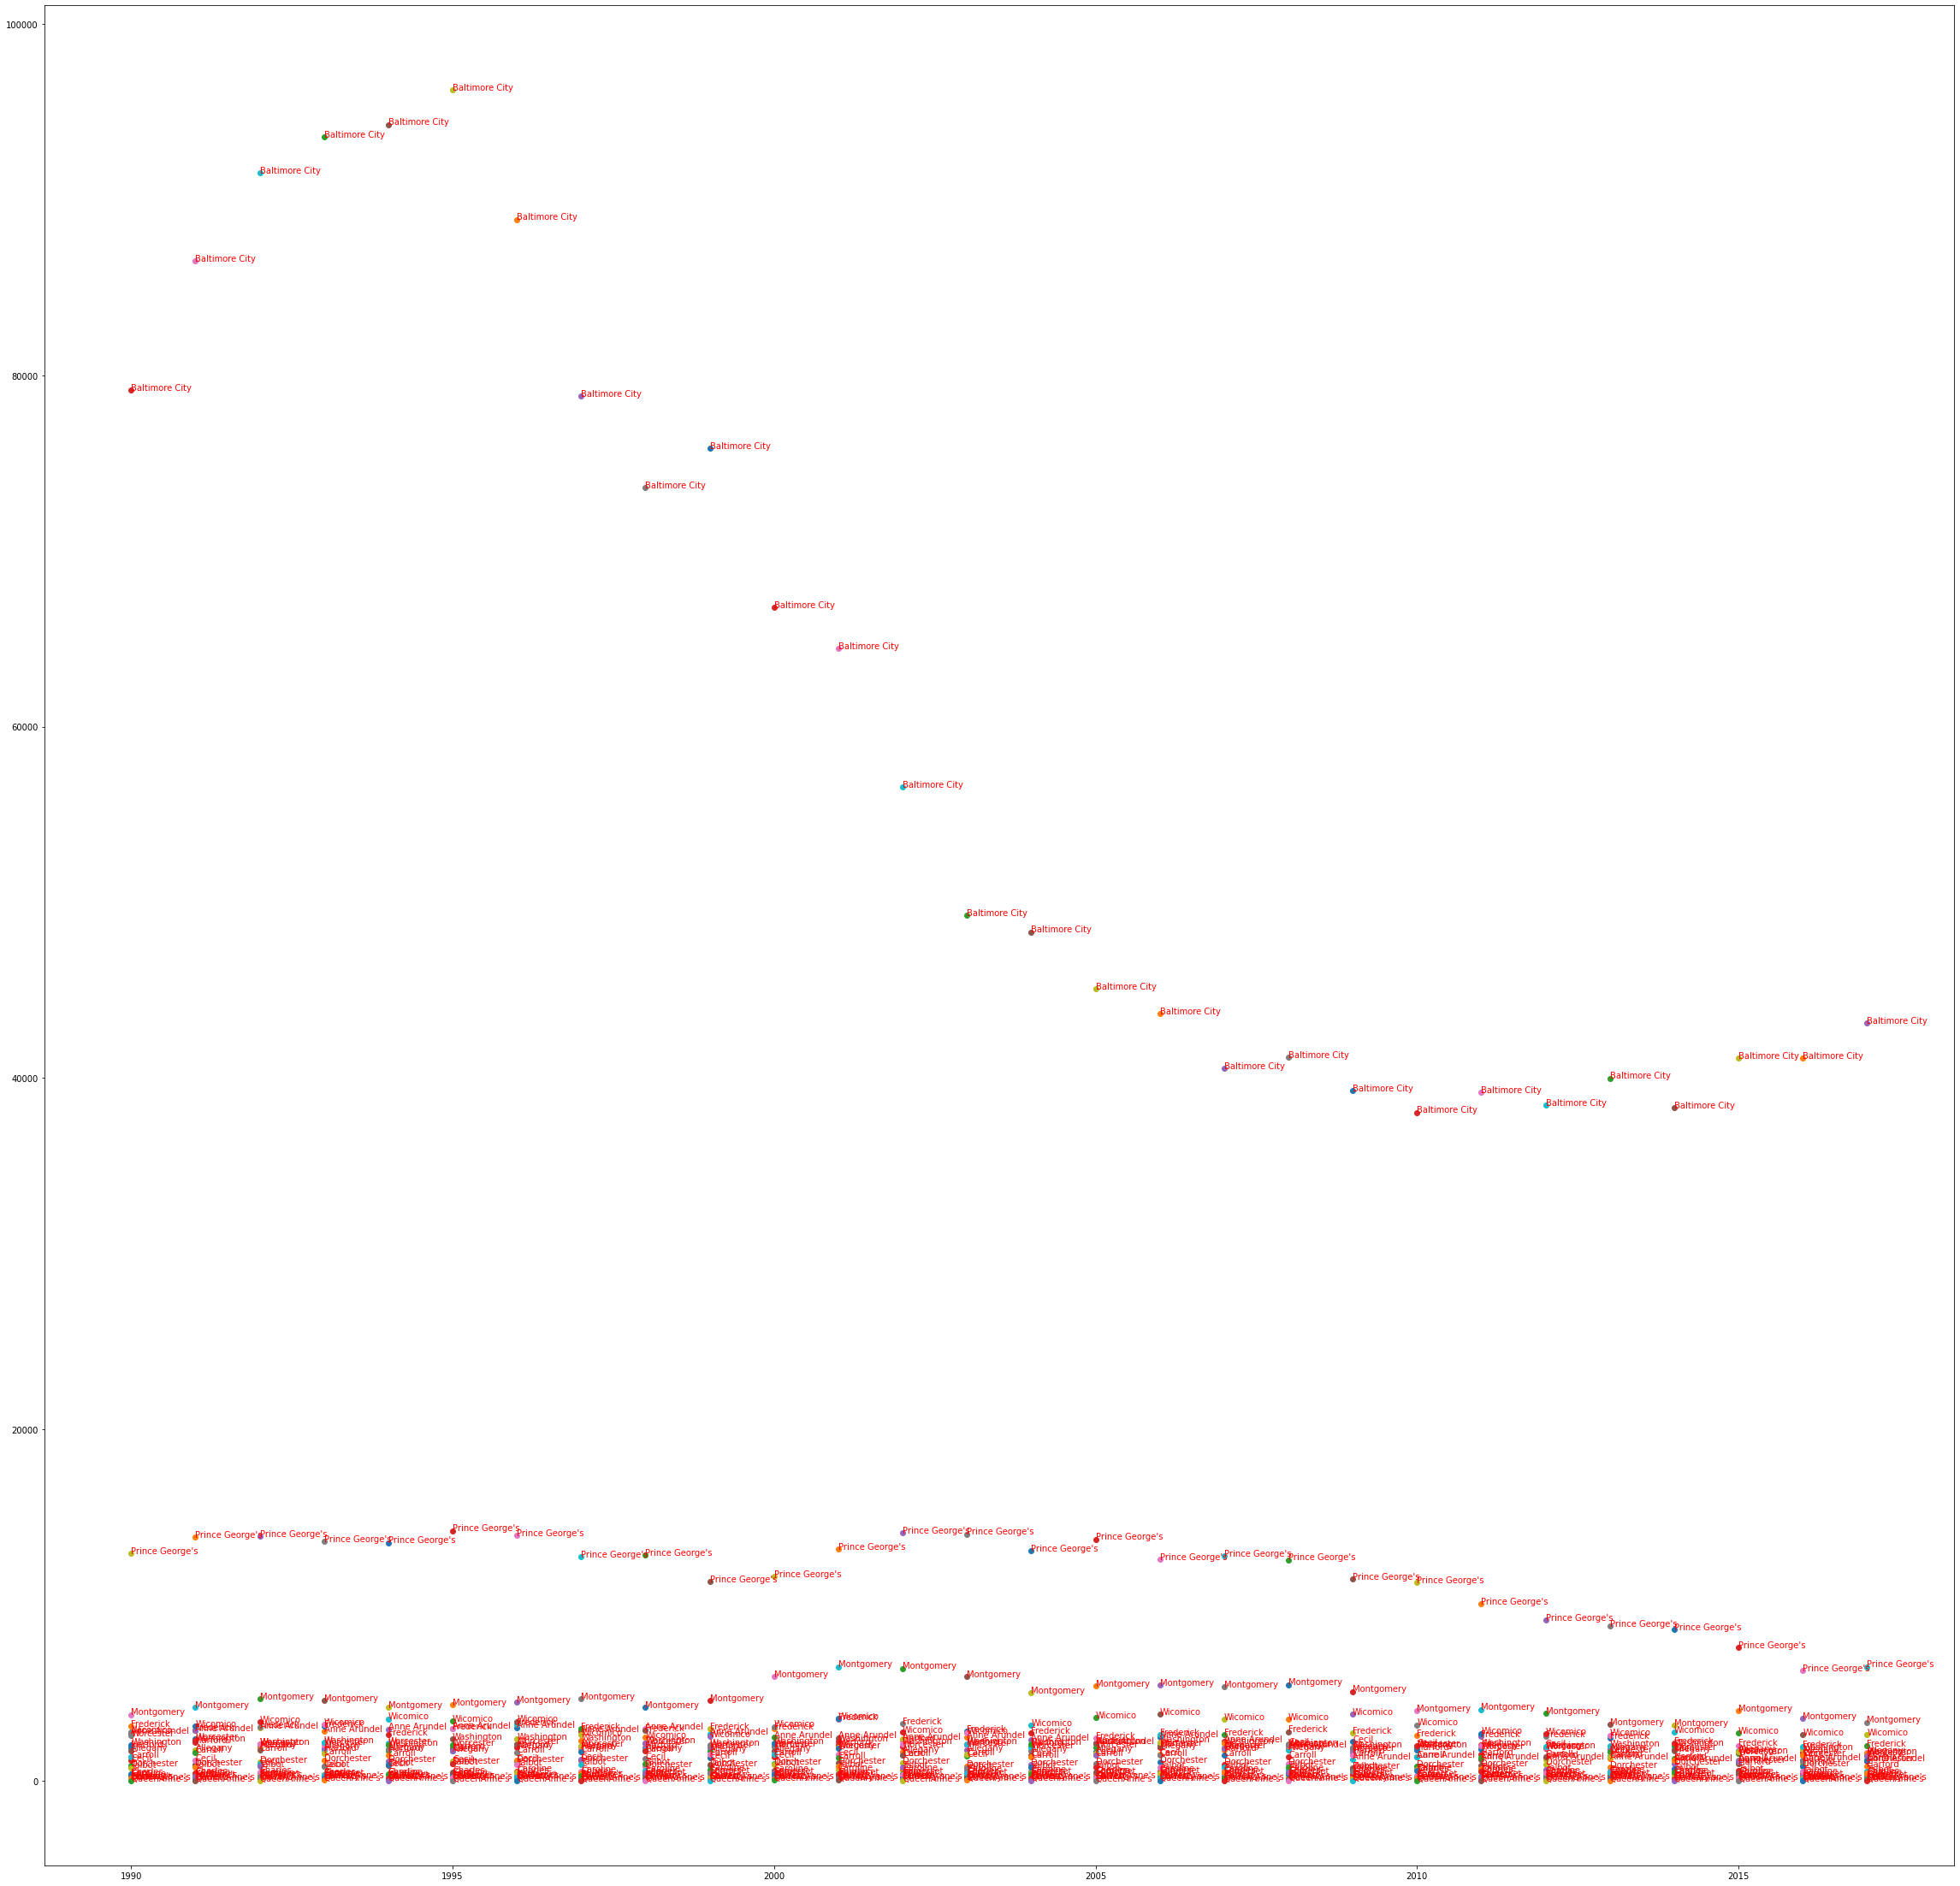

In [176]:
plt.subplots(figsize = (40, 40))
for i in range(0,len(cleaned_df.index)):
    plt.scatter(cleaned_df.iat[i,2], cleaned_df.iat[i,4] )
    plt.text(cleaned_df.iat[i,2], cleaned_df.iat[i,4],cleaned_df.iat[i,1],color = "red")

## Analysis of 1st version of graph:

From the graph, all data are too close to each other because of the existence of Baltimore City and Prince George's. It is impossible to eyeball a trend based on those data, even though we enlarge the size of graph.

In that case, we assume the large number crime of certain county is because of the large population. Then we make a simliar graph for population of each comry.

In [ ]:
plt.subplots(figsize = (40, 40))
for i in range(0,len(cleaned_df.index)):
    plt.scatter(cleaned_df.iat[i,2], cleaned_df.iat[i,3] )
    plt.text(cleaned_df.iat[i,2], cleaned_df.iat[i,3],cleaned_df.iat[i,1],color = "red")

Clearly, we can see that the population of Baltimore City and Prince George's are higher than other counties. Then we conduct a new graph that is based on the total crime number / total population (crime ratio).

## Second Version of Graph

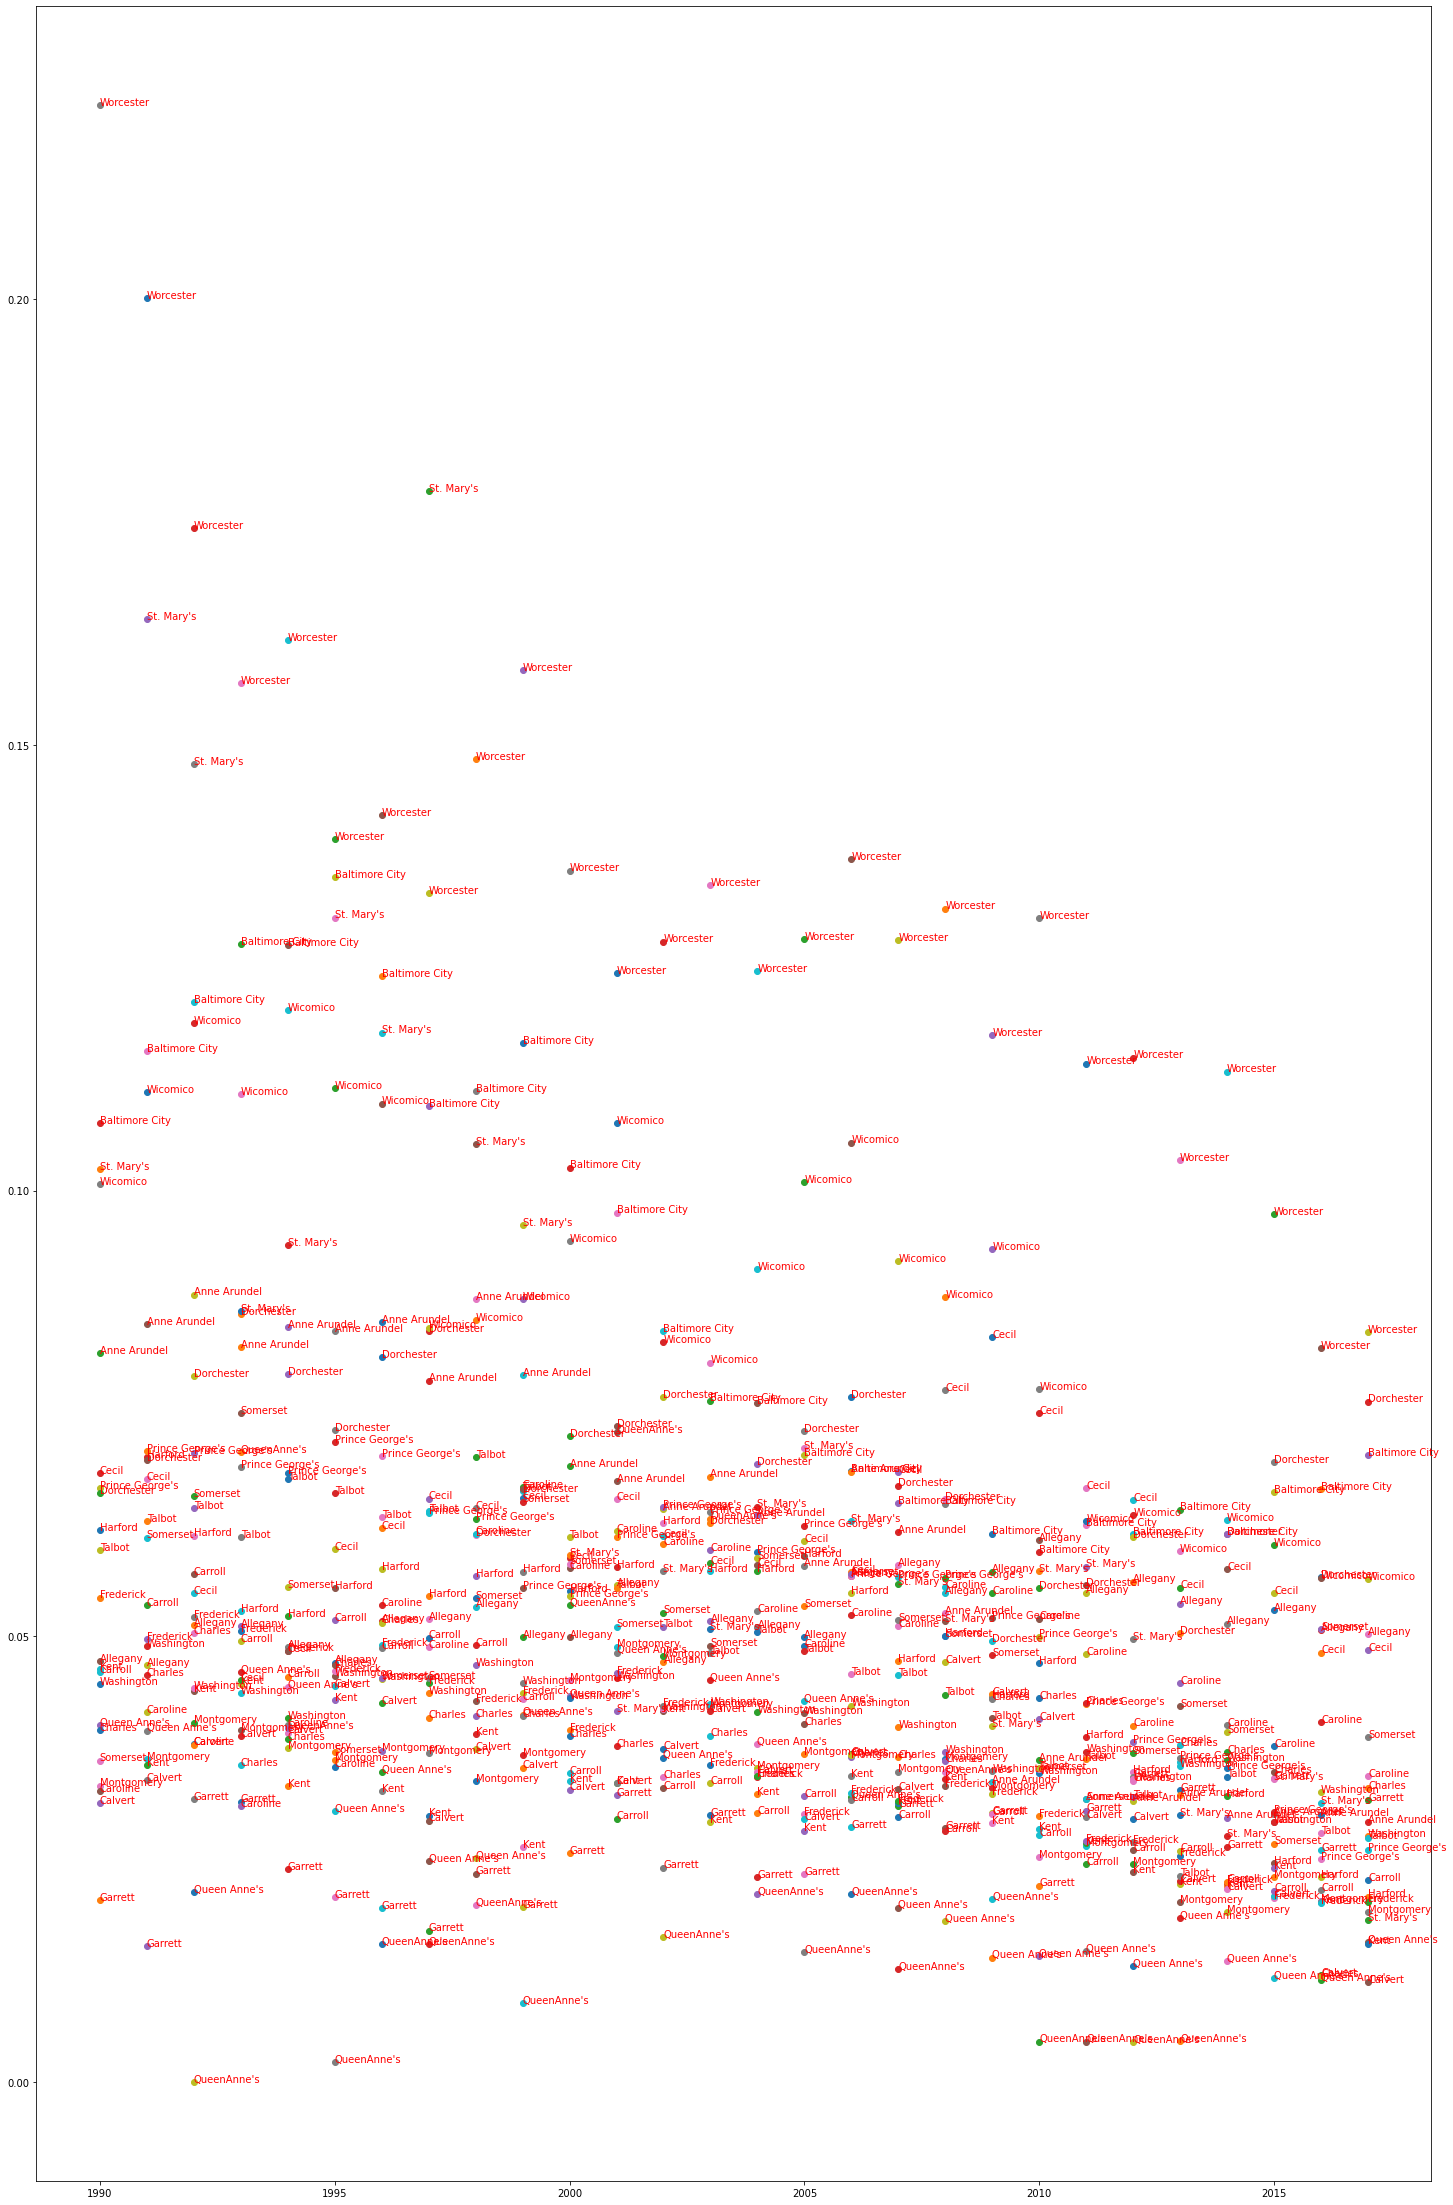

In [107]:
plt.subplots(figsize = (25, 40))
for i in range(0,len(cleaned_df.index)):
    plt.scatter(cleaned_df.iat[i,2], cleaned_df.iat[i,7] )
    plt.text(cleaned_df.iat[i,2], cleaned_df.iat[i,7],cleaned_df.iat[i,1],color = "red")

## Analysis of 2nd version of graph:

The data is relatively spread out but it is still hard to see the trend based on those points. One reason is that ther are too many points though they have different color, and labels. Second reason is scatter polt is hard to see trends.

In that case, we decide to plot a thrid version of graph. For too many points, we make separate graphs for each county. For disadvantages of scatter plot, we change to line plot.

## Third Version of Graph

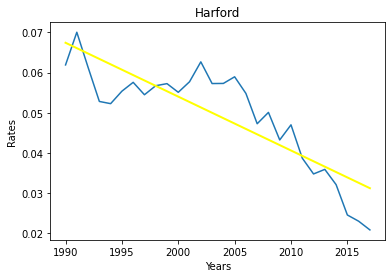

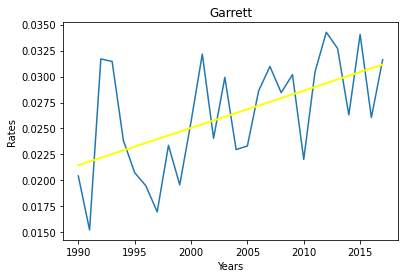

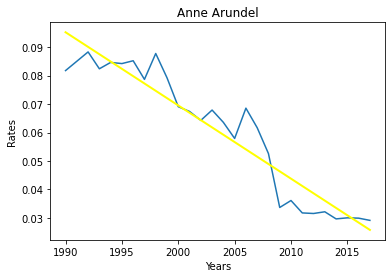

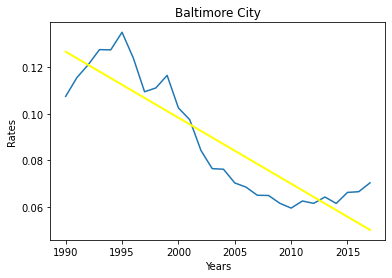

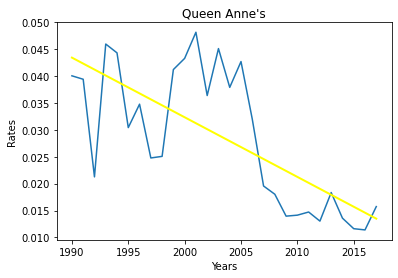

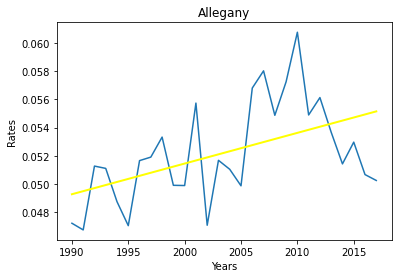

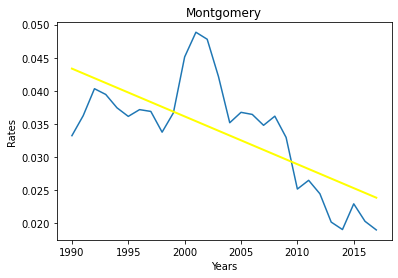

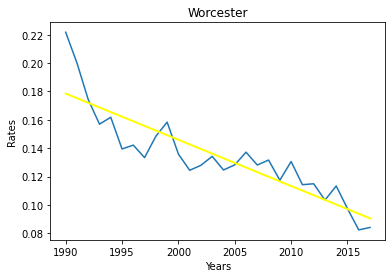

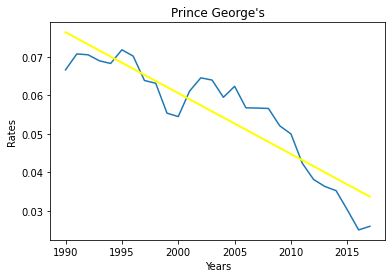

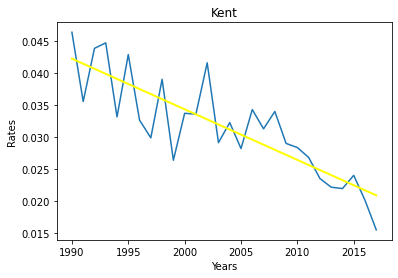

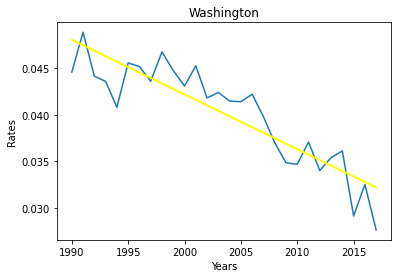

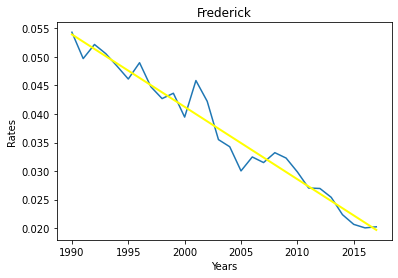

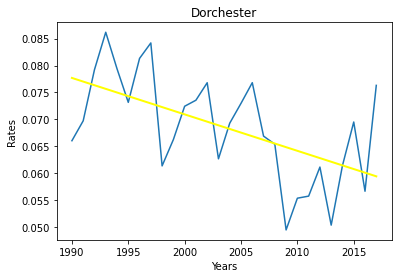

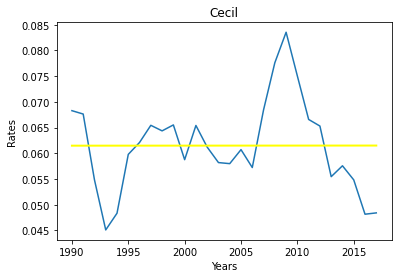

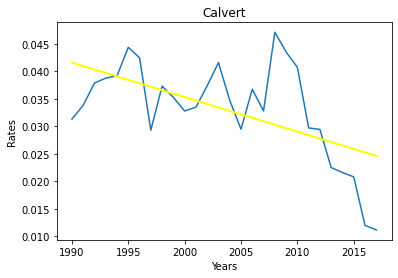

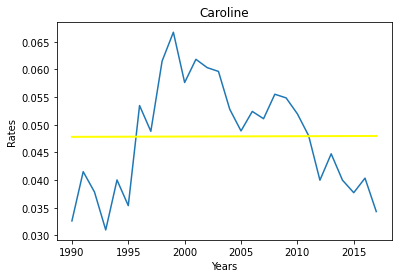

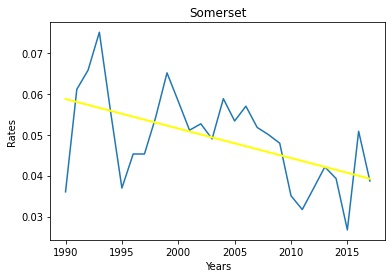

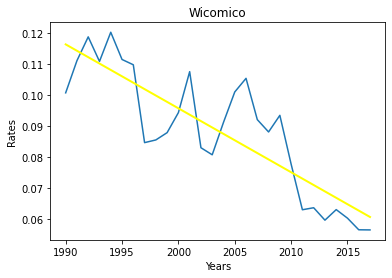

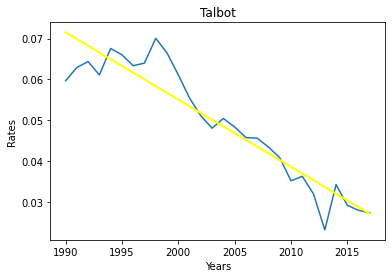

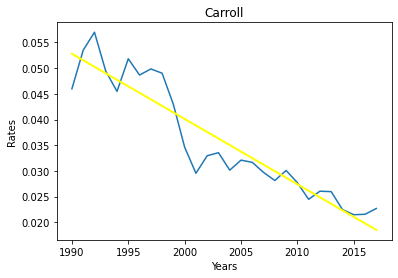

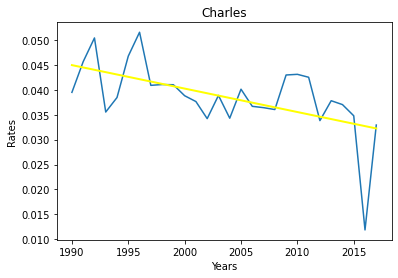

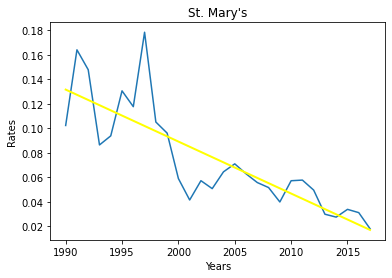

In [108]:
for name in counties:
    if name != "QueenAnne's":
        rate = []
        year = []
        for i in range(0,len(cleaned_df.index)):
            if cleaned_df.iat[i,2] and cleaned_df.iat[i,1] == name:
                rate.append(cleaned_df.iat[i,7])
                year.append(cleaned_df.iat[i,2])
    
        plt.title(name)
        plt.xlabel("Years")
        plt.ylabel("Rates")
        plt.plot(year, rate)
    
        #Add regression line for each graph.
        reg = linear_model.LinearRegression()
        if len(year)!= 0 and len(rate)!= 0:
            year2 = np.array(year).reshape(-1,1)
            rate2 = rate#.tolist()
            regfit = reg.fit(year2, rate2)
            y = reg.predict(year2)
            plt.plot(year2, y, color = 'yellow', linewidth = 2)
            plt.show()
    

## Analysis of 3rd version of graph:

We show the trend of crime ration change clearly for each county and conduct a linear regression for each graph. We can see clearly most of the trends show that as time goes, the overall crime ratio decreases. However, there are still some graphs that the trends is even or increasing like Garrett and Allegany(increasing), Caroline and Cecil(not changing much). 

As mentioned above, not every county's crime ratio trend has the same direction. What about the total trend? Based on that question, we make the fouth graph.

## Fourth Version of Graph

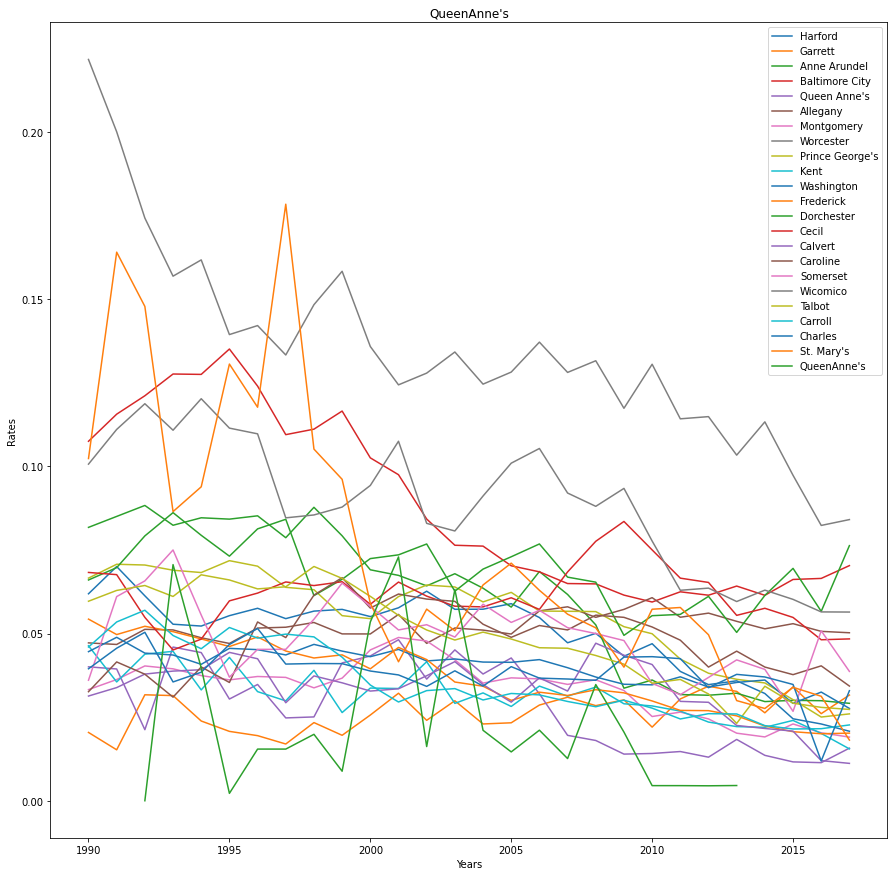

In [109]:
plt.subplots(figsize = (15, 15))
for name in counties:
    rate = []
    year = []
    for i in range(0,len(cleaned_df.index)):
        if cleaned_df.iat[i,2] and cleaned_df.iat[i,1] == name:
            rate.append(cleaned_df.iat[i,7])
            year.append(cleaned_df.iat[i,2])    
    plt.title(name)
    plt.xlabel("Years")
    plt.ylabel("Rates")
    plt.plot(year, rate, label = name)
    plt.legend()
plt.show()

Then we add a regression line to the graph. 

## Final Version of Graph:

ValueError: Input y contains NaN.

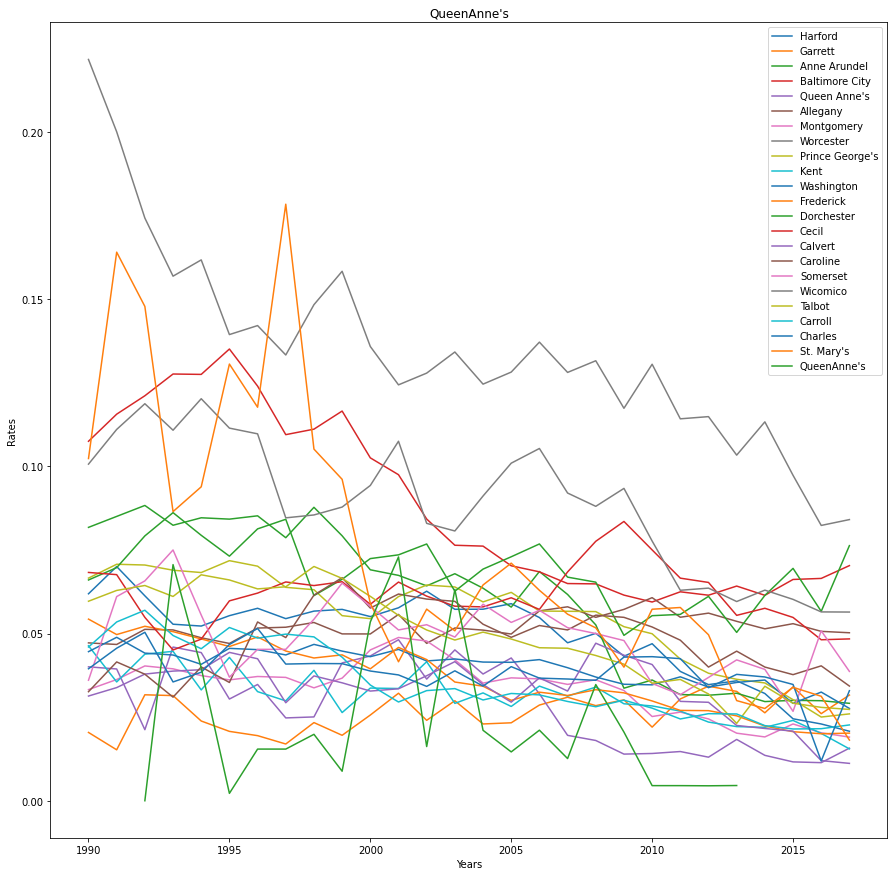

In [110]:
plt.subplots(figsize = (15, 15))
for name in counties:
    rate = []
    year = []
    for i in range(0,len(cleaned_df.index)):
        if cleaned_df.iat[i,2] and cleaned_df.iat[i,1] == name:
            rate.append(cleaned_df.iat[i,7])
            year.append(cleaned_df.iat[i,2])    
    plt.title(name)
    plt.xlabel("Years")
    plt.ylabel("Rates")
    plt.plot(year, rate, label = name)
    plt.legend()
reg = linear_model.LinearRegression()
   # year2 = cleaned_df['year'].values.reshape(-1,1)
if len(year)!=0 and len(rate)!=0:
    year2 = cleaned_df['year'].values.reshape(-1,1)
    rate2 = cleaned_df["crime ratio"].array
    regfit = reg.fit(year2, rate2)
    y = reg.predict(year2)
    plt.plot(year2, y, color = 'BLACK', linewidth = 5)
    plt.show()
#plt.show()

In [111]:
with open('Final_Project.ipynb') as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

1080


In [112]:
with open('Final_Project.ipynb') as json_file:
    data = json.load(json_file)

codeLineCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "code":
        content = each['source']
        for line in content:
            codeLineCount = codeLineCount + 1
            
print(codeLineCount)

259


# Conclusion:

The crime ratio(total crime number over population) of Maryland is decreasing as time goes. Though, there are county like Baltimore and Prince George's that the crime number is large, the crime ration is decreasing. 

We are happy to see this result based on our analysis. It means that, even if there are ups and downs in the past 30 years, the society of Maryland State is going towards a more safe and stable environment. For further research, we can also conduct the relationship between violent crime and property crime in the past 30 years.